In [ ]:
import splitfolders

input_folder = r"C:\Users\admin\OneDrive\BE project\BEeyeProject\dataset"
output_folder = r"C:\Users\admin\OneDrive\BE project\BEeyeProject\dataset-split"

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir=r"dataset-split/train"
val_data_dir=r"dataset-split/val"

# from keras.layers.preprocessing.image_preprocessing import HORIZONTAL

train_datagen=ImageDataGenerator(horizontal_flip= True)

val_datagen=ImageDataGenerator()

img_width,img_height=224,224
batch_size=32
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  
                                                  shuffle= True,
                                                  class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                         
                                              shuffle= False,
                                              class_mode='categorical')

train_class_names = set()
num_train_samples=0
for i in train_generator.filenames:
    train_class_names.add(i.split('\\')[0])
    num_train_samples+=1
print(num_train_samples)
train_class_names

val_class_names = set()
num_val_samples=0
for i in val_generator.filenames:
    val_class_names.add(i.split('/')[0])
    num_val_samples+=1
print(num_val_samples)
print(val_class_names)

num_classes = len(val_class_names)
num_classes

Found 4314 images belonging to 5 classes.
Found 536 images belonging to 5 classes.
4314
536
{'diabetic_retinopathy', 'cataract', 'AMD', 'glaucoma', 'normal'}


5

In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = EfficientNetV2B2(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False,
                    include_preprocessing=True,
                    )
# Freeze the first 10 layers
base_model.summary()

2024-01-13 13:42:28.302560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 13:42:28.437848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-13 13:42:28.443523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [5]:
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
x = Conv2D(256,(3,3),activation='relu')(x)
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
checkpoint = ModelCheckpoint("radha_Beta.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

epochs=20

In [7]:
model1.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.0001),
                   metrics=['accuracy', tf.keras.metrics.AUC()])
history1 = model1.fit(train_generator,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=val_generator,
                         validation_steps=num_val_samples//batch_size)

Epoch 1/20


2024-01-13 13:43:03.987113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-13 13:43:06.081237: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-13 13:43:06.082402: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-13 13:43:06.082411: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-01-13 13:43:06.082445: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling ba

  1/134 [..............................] - ETA: 1:11:11 - loss: 5.8038 - accuracy: 0.1250 - auc: 0.4402

2024-01-13 13:43:23.157068: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-13 13:43:23.248259: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



134/134 [==============================] - ETA: 0s - loss: 4.4967 - accuracy: 0.6730 - auc: 0.9092
Epoch 1: val_loss improved from inf to 3.70780, saving model to radha_Beta.h5


/home/admin1/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 98s 493ms/step - loss: 4.4967 - accuracy: 0.6730 - auc: 0.9092 - val_loss: 3.7078 - val_accuracy: 0.8438 - val_auc: 0.9750
Epoch 2/20
134/134 [==============================] - ETA: 0s - loss: 3.3936 - accuracy: 0.8461 - auc: 0.9737
Epoch 2: val_loss improved from 3.70780 to 2.98909, saving model to radha_Beta.h5
134/134 [==============================] - 60s 444ms/step - loss: 3.3936 - accuracy: 0.8461 - auc: 0.9737 - val_loss: 2.9891 - val_accuracy: 0.8574 - val_auc: 0.9840
Epoch 3/20
134/134 [==============================] - ETA: 0s - loss: 2.6712 - accuracy: 0.8944 - auc: 0.9865
Epoch 3: val_loss improved from 2.98909 to 2.40135, saving model to radha_Beta.h5
134/134 [==============================] - 59s 441ms/step - loss: 2.6712 - accuracy: 0.8944 - auc: 0.9865 - val_loss: 2.4014 - val_accuracy: 0.9023 - val_auc: 0.9865
Epoch 4/20
134/134 [==============================] - ETA: 0s - loss: 2.1379 - accuracy: 0.9150 - auc: 0.9910
Epoch 4:

In [12]:
from sklearn.metrics import classification_report
import numpy as np
# Assuming you have test data in a separate directory
test_data_dir = "/home/admin1/dataset/test"
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

# Predict on the test set
y_pred = model1.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to class labels
y_pred_classes = [np.argmax(pred) for pred in y_pred]
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))


Found 545 images belonging to 5 classes.
18/18 [==============================] - 8s 486ms/step
Classification Report:
                      precision    recall  f1-score   support

                 AMD       1.00      0.94      0.97        79
            cataract       0.91      0.95      0.93       105
diabetic_retinopathy       0.87      0.96      0.91       121
            glaucoma       0.89      0.86      0.88       102
              normal       0.89      0.83      0.86       138

            accuracy                           0.90       545
           macro avg       0.91      0.91      0.91       545
        weighted avg       0.90      0.90      0.90       545



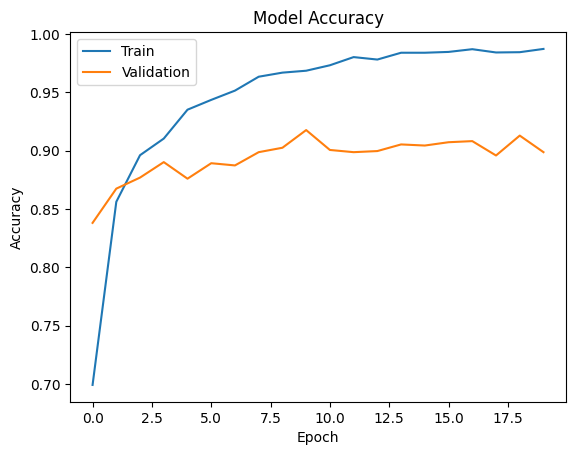

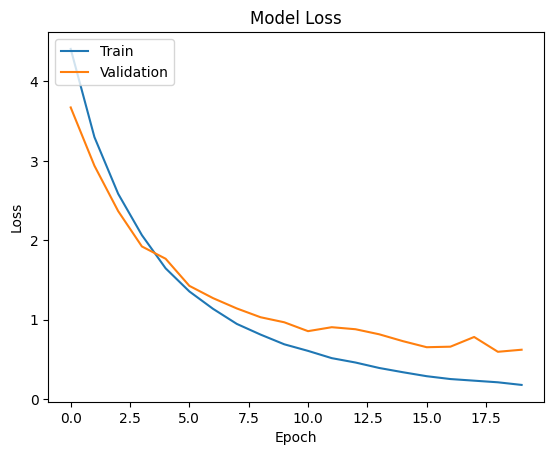

In [9]:
history = history1
import os
from matplotlib import pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the accuracy plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/EfficientNet accuracy.png')

# Plotting the loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Saving the loss plot
if not os.path.exists('graphs'):
    os.makedirs('graphs')
plt.savefig('graphs/EfficientNet loss.png')